<a href="https://colab.research.google.com/github/kirill-kozlitin/Coworking/blob/main/%D0%9A%D0%BE%D0%B2%D0%BE%D1%80%D0%BA%D0%B8%D0%BD%D0%B3_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BA%D0%BE%D0%BC%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%B8%D0%B5%D0%B2_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Импорт бибилиотек

In [3]:
pip install pymorphy2

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import pymorphy2
from sklearn.svm import SVC




#

# # Выведите результат
# for combination in all_combinations:
#     print(combination)
# Этот код создаст все возможные комбинации
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Загрузка комментариев

In [6]:
path = '/content/drive/MyDrive/Коворкинг/Выборки/'
data = pd.read_excel(path + 'Комментарии.xlsx')

#### Предобработка

In [7]:
data[['Название', 'Адрес']] = data[['Название', 'Адрес']].ffill()

In [8]:
data.head()

,Название,Адрес,Отзыв,Оценка
0,& Place,"Невский проспект, 71/1","Место, сделанное людьми для людей. Удобное рас...",5.00
1,& Place,"Невский проспект, 71/1","Обожаю это место. Живу не в питере, но в после...",5.00
2,& Place,"Невский проспект, 71/1",Суперкомфоотный коворкинг для работы! Уже боль...,5.00
3,& Place,"Невский проспект, 71/1",Супер место. Чистота везде и всегда. Кофе - де...,5.00
4,& Place,"Невский проспект, 71/1","Выбирали из множества вариантов, но этот ковор...",5.00


#### Аналитика

In [9]:
# Создание объекта pymorphy2 для лемматизации слов
morph = pymorphy2.MorphAnalyzer()

In [10]:
# Загрузка списка русских стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Функция для лемматизации и удаления стоп-слов из текста
def preprocess_text(text):
    words = text.split()
    words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    return ' '.join(words)

In [13]:
# Удаление стоп-слов из отзывов
data['Отзыв'] = data['Отзыв'].apply(preprocess_text)

In [14]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Обучение векторизатора и преобразование отзывов в векторное пространство
review_vectors = vectorizer.fit_transform(data['Отзыв'])

# Сохранение векторных представлений в DataFrame
data['Отзыв _ вектор'] = list(review_vectors.toarray())


In [15]:
data.dropna(axis='index', inplace=True)

Accuracy: 0.6666666666666666


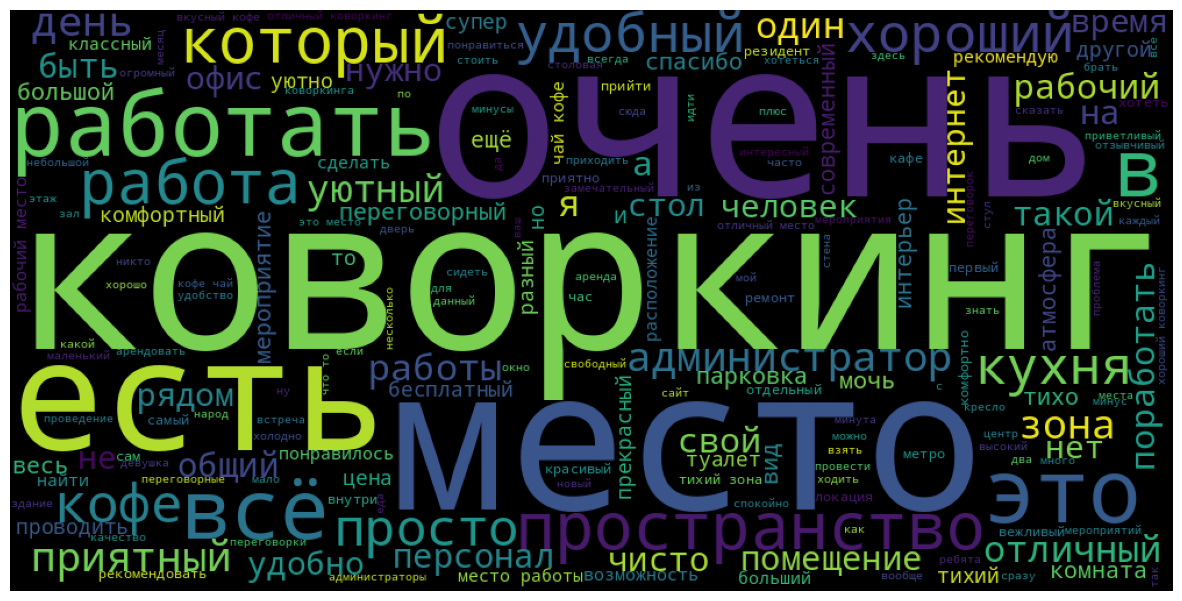

In [16]:

# Преобразование списков векторов в матрицу признаков
X = np.stack(data['Отзыв _ вектор'].values)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, data['Оценка'], test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
score = model.score(X_test, y_test)
print(f"Accuracy: {score}")

# Создание облака слов
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(data['Отзыв']))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Оценка влияния слов на рейтинг отзыва

In [17]:
# Получение списка слов
words = vectorizer.get_feature_names_out()

# Получение коэффициентов модели
coefficients = model.coef_[0]

# Создание DataFrame с словами и их коэффициентами
word_importances = pd.DataFrame({'word': words, 'coefficient': coefficients})

# Сортировка слов по абсолютному значению коэффициента
word_importances = word_importances.reindex(word_importances.coefficient.abs().sort_values(ascending=False).index)

# Вывод 10 наиболее важных слов
print(word_importances.head(10))

                word  coefficient
2043  отвратительный         0.75
1329            кофе        -0.63
1480            мало         0.60
1727              не         0.57
2086        отличный        -0.55
459              всё        -0.55
237            брать         0.53
2138           очень        -0.52
2659        приятный        -0.51
799             есть        -0.49


Выввод: Наиболее значимые слова для рейтинга:

1. Отвратительный - сильнее всего занижает оценку
1. Кофе сильнее всего ее повышает
1. Мало, воздуха, вылетает - тоже сильно занижают. Скорее всего имеется виду мало места, воздуха и нестабильный интернет.

При этом этот перечень факторов все равно содержит много слов паразитов которые мешают анализу. Надо будет пофиксить

Далее разберем все словосочетания и посмотрим более глубоко что влияет на оценку

 #### Анализ 2-3 составленных словосочетаний

In [18]:
# Создание объекта TfidfVectorizer с использованием 2-грамм и 3-грамм
vectorizer = TfidfVectorizer(ngram_range=(2, 3))

# Обучение векторизатора и преобразование отзывов в векторное пространство
review_vectors = vectorizer.fit_transform(data['Отзыв'])

# Сохранение векторных представлений в DataFrame
data['Отзыв _ вектор'] = list(review_vectors.toarray())

# Преобразование списков векторов в матрицу признаков
X = np.stack(data['Отзыв _ вектор'].values)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, data['Оценка'], test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
score = model.score(X_test, y_test)
print(f"Accuracy: {score}")

# Получение списка слов и словосочетаний
words = vectorizer.get_feature_names_out()

# Получение коэффициентов модели
coefficients = model.coef_[0]

# Создание DataFrame с словами и их коэффициентами
word_importances = pd.DataFrame({'word': words, 'coefficient': coefficients})

# Сортировка слов по абсолютному значению коэффициента
word_importances = word_importances.reindex(word_importances.coefficient.sort_values(ascending=False).index)

# Вывод 10 наиболее важных слов и словосочетаний
print(word_importances.head(20))

Accuracy: 0.6559139784946236
                               word  coefficient
8087                    мало воздух         0.69
11369       отвратительный персонал         0.69
5517             интернет постоянно         0.27
5518    интернет постоянно вылетать         0.27
13879            постоянно вылетать         0.27
1795     вкусный интернет постоянно         0.27
11887                    оч удобный         0.27
19359       удобный место сожаление         0.27
8707                место сожаление         0.27
11888              оч удобный место         0.27
17460        сожаление велопарковка         0.27
8708   место сожаление велопарковка         0.27
222                          fi мда         0.27
6164                коворкинг wi fi         0.27
6163                   коворкинг wi         0.27
310                       wi fi мда         0.27
8181                       мда треш         0.27
223                     fi мда треш         0.27
1320              вайфай обрываться     

Вывод:
1. Больше всего проблем доставляет персонал. Именно он имеет сильнейшее влияние на оценку отзыва.
1. Мало воздуха - тоже наиболее сильный фактор. То есть речь идет либо о кондиционировании, либо о плотности в коворкинге.
1. Вылетающий интернет - разделил аж 3 позиции (и множество позиций ниже). Вероятно, если бы был более точный контекст, то этот фактор бы оказался самым сильным или одним из. В общем, тоже важный фактор.
1. Отсутствие велопарковки замыкает круг.


In [19]:
print(word_importances.tail(20))

                       word  coefficient
14174      прекрасный место        -0.09
1442      вежливый персонал        -0.09
20163     хороший коворкинг        -0.09
12131          очень уютный        -0.09
16480           рядом метро        -0.09
12121         очень удобный        -0.09
19833          уютный место        -0.09
8597            место очень        -0.10
14247  приветливый персонал        -0.10
8656           место работа        -0.11
19390  удобный расположение        -0.11
6051     классный коворкинг        -0.11
1798           вкусный кофе        -0.13
11623        отличный место        -0.13
10215        неудобный вход        -0.13
8563        место неудобный        -0.14
7330               кофе чай        -0.14
8667           место работы        -0.17
11601    отличный коворкинг        -0.19
20554              чай кофе        -0.19


К факторам положительно влияющими на оценку:
1. Наличие чая и кофе
1. Отдельно влияет именно вкусный кофе (часто об этом упоминалось отдельно)
1. Уют места и приветливый персонал тоже положительно влияют.
1. Положительно влияет и близость к метро.

Удивительно, что "зимой очень холодно", "неудобный вход", "места неудобные" - при наличии таких фраз отзыв оказывался скорее положительным


#### Обучение word2vec для анализа контекста

In [20]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [71]:
from gensim.models.phrases import Phrases, Phraser

import nltk
nltk.download('punkt')
from nltk.util import ngrams

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

def extract_ngrams(text, n):
  tokens = nltk.word_tokenize(text)
  return [' '.join(gram) for gram in ngrams(tokens, n)]

# Пример использования для 2-грамм
reviews_bigram = [extract_ngrams(' '.join(review), 2) for review in reviews]

model_bigram = Word2Vec(sentences=reviews_bigram, vector_size=100, window=5, min_count=1, workers=4)

# Усреднение векторов n-грамм для каждого отзыва
review_vectors_bigram = [np.mean([model_bigram.wv[ngram] for ngram in review if ngram in model_bigram.wv], axis=0) for review in reviews_bigram]

# Создание DataFrame с векторами и оценками
data_vec = pd.DataFrame({'Отзыв_вектор': review_vectors_bigram, 'Оценка': data['Оценка']})

# Разделение данных на признаки (X) и целевую переменную (y)
X = np.stack(data_vec['Отзыв_вектор'].values)
y = data_vec['Оценка']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели SVM с линейным ядром
model_svm = LinearSVC()
model_svm.fit(X_train, y_train)

# Оценка модели на тестовой выборке
score = model_svm.score(X_test, y_test)
print(f"Accuracy: {score}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy: 0.6559139784946236


In [80]:
# Получение коэффициентов модели
coefficients_svm = model_svm.coef_[0]

# Умножение вектора каждой n-граммы на коэффициенты SVM
ngram_importances_values = [np.dot(model_bigram.wv[ngram], coefficients_svm) for ngram in model_bigram.wv.index_to_key]

# Нормализация коэффициентов важности
scaler = MinMaxScaler()
ngram_importances_values = scaler.fit_transform(np.array(ngram_importances_values).reshape(-1, 1)).flatten()

# Создание DataFrame с n-граммами и их нормализованной важностью
ngram_importances = pd.DataFrame({'ngram': model_bigram.wv.index_to_key, 'importance': ngram_importances_values})

# Сортировка n-грамм по важности
ngram_importances = ngram_importances.sort_values(by='importance', ascending=False)

# Вывод 10 наиболее важных n-грамм
print(ngram_importances.head(20))

                        ngram  importance
9648           время резидент        1.00
8403          плохой качество        0.99
8499       записываться ранее        0.96
533              есть большой        0.96
8426              мало воздух        0.95
8275          петербург понял        0.94
9846      работать праздникам        0.93
502        сотрудники удобный        0.93
2224            коворкинг час        0.93
4159       witnessed документ        0.92
4252  отвратительный персонал        0.92
5438          работать второй        0.92
4416              вход сложно        0.91
3191  доставлять беспокойство        0.91
8865              работает из        0.90
457               кресло стол        0.90
7400           кресло удобное        0.90
7639            шоке вериться        0.89
8892         невозможно тихий        0.87
5528            итог менеджер        0.87


Здесь наиболее значимыми для оценки являются такие факторы:
1. Необходимость записываться заранее
1. Плотность (мало воздуха)
1. Возмжность работать по праздникам
1. отвратительный персонал
1. Сложность в нахождении входа
1. Удобство кресел
1. Наличие возможности тихо работать чтобы никто не беспокоил

### Анализ тональности

#### Определим на основании текста комментариев тональность содержимого

Загружаем датасет

In [95]:
path = '/content/drive/MyDrive/Коворкинг/Выборки/'
df_sent = pd.read_excel(path + 'text_rating_final.xlsx', header=None, usecols=[0, 1])

In [115]:
df_sent.rename({0:'text', 1:'label'}, axis='columns', inplace=True)
df_sent.dropna(axis='index', inplace=True)
df_sent = df_sent.loc[df_sent['label'].isin([-2, -1, 0, 1, 2])]

In [116]:
# Учитываем отдельные слова, биграммы и триграммы
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf_vectorizer.fit_transform(df_sent['text'])

In [120]:
y = df_sent['label']
y = y.astype(int)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели SVM с ядром RBF
model_svm = SVC(kernel='rbf', C=1, gamma='scale')  # C и gamma - это гиперпараметры, которые можно настроить
model_svm.fit(X_train, y_train)

score = model_svm.score(X_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.5495523309663476


In [129]:
# Преобразование комментариев с использованием TF-IDF
comments_vectorized = tfidf_vectorizer.transform(data['Отзыв'])

# Получение предсказаний
predicted_sentiments = model_lr.predict(comments_vectorized)

In [130]:
data['Тональность'] = predicted_sentiments

In [131]:
data.loc[data['Тональность'] == -1]

,Название,Адрес,Отзыв,Оценка,Отзыв _ вектор,Тональность
189,Ясная поляна,"Льва Толстого, 1/3",ужасно медленный интернет. в течение день выда...,1.00,"[-0.0031598073, 0.003524391, 0.0011559323, 0.0...",-1
190,Ясная поляна,"Льва Толстого, 1/3","когда сюда заходить - вау. а факту, долго, хол...",2.00,"[-0.002744865, 0.0012795841, 0.002312364, -0.0...",-1
198,Ясная поляна,"Льва Толстого, 1/3","всё норм, организация гардероб немного портит,...",3.00,"[0.00082233106, 0.001498015, 0.0019011876, 0.0...",-1
199,Ясная поляна,"Льва Толстого, 1/3","митапа альфа-банк норм, 1. толкучка вход 2. на...",3.00,"[-9.6330994e-05, 0.0019711098, 0.004002033, -0...",-1
226,Benua Page,"Тихорецкий проспект, 17 лит Б","очень модный место, плюс заканчиваются. супер ...",3.00,"[-0.0021585124, 0.004561837, 0.0011561583, 0.0...",-1
227,Benua Page,"Тихорецкий проспект, 17 лит Б","камин, лофт, чай\кофе (когда кофейный ведёрко ...",4.00,"[-0.0029161857, 0.0022636305, -0.00029070355, ...",-1
229,Benua Page,"Тихорецкий проспект, 17 лит Б",в целое понравилось. удобно заскочить поработа...,4.00,"[-0.0023978816, 0.00013961465, -0.0013748972, ...",-1
273,Colab,"Звенигородская, 9-11","отличный местечко, абсолютно всё полноценный р...",4.00,"[-0.003033492, 0.0028056786, 0.0016803367, 0.0...",-1
334,Growup,"Большой Сампсониевский проспект, 61",неплохо. только кондиционер несчадно морозить ...,4.00,"[-0.0028296404, -0.0014935894, 0.0009193725, -...",-1
335,Growup,"Большой Сампсониевский проспект, 61",работать 2 месяца. ресепшн вежливый главное пр...,5.00,"[-0.0006106453, 0.000112088164, 0.000502194, -...",-1


In [135]:
data.loc[335, 'Отзыв']

'работать 2 месяца. ресепшн вежливый главное просторно, спокойно куча народ бесплатном.'

Вывод: Анализ тональности не получилось провести в полной мере. Полученные результаты важной информации не несут.

Обучение на нейронных сетях типа BERT оказалось громоздким и дорогим. Конечного результата я не добился.